# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [1]:
import emcee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('line_fitting.csv')
df.head()

,Unnamed: 0,x,y,y_err
0,0,0.596779,8.112571,0.160314
1,1,0.921049,3.528151,0.513170
2,2,1.156184,4.810234,0.401530
3,3,1.754518,0.892382,0.372534
4,4,1.824917,3.132952,0.271382


In [3]:
def plot_data(ax, x, y, y_err):
    ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=3, ms=2, c='k')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.tick_params(axis='both', which='major', top=True)
    ax.tick_params(axis='both', which='minor', top=True)
    ax.tick_params(direction='in')

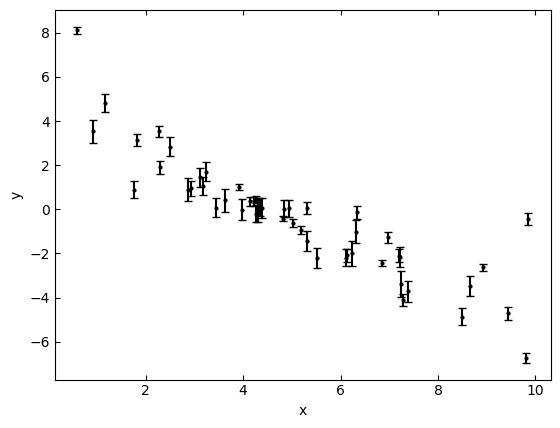

In [4]:
fig, ax = plt.subplots()
plot_data(ax, df['x'], df['y'], df['y_err'])

In [5]:
def get_model_predictions(theta, x):
    '''
    Calculate the model at any position x
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    Returns
    -------
    model_preds : arr-like, shape (n_samples)
        Array of model values
    '''
    m, b = theta
    model_preds = m*x+b
    
    return model_preds

In [6]:
def lnlikelihood(theta, y, x, y_unc):
    '''
    Calculate the log likelihood for a model assuming Gaussian uncertainties
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    model_preds = get_model_predictions(theta, x)
    n = len(y)
    K = -n/2*np.log(2*np.pi) - np.sum(np.log(y_unc))
    #print((y-model_preds(theta, x))**2)
    #lnl = K - np.sum([(y_obs - model_preds(theta, x_temp))**2/(2*y_err**2) for y_obs, x_temp, y_err in zip(y, x, y_unc)])
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

In [7]:
def lnprior(theta):
    '''
    Calculate the log of the prior for the model parameters
    
    Parameters
    ----------
    theta : tuple
        Model parameters
            
    Returns
    -------
    lnp : float
        The log-prior of the model parameters
    '''
    m, b = theta
    if -10 <= m <= 0 and 0 <= b <= 10:
        lnp = np.log(1/10) + np.log(1/10) # assumes P(m) and P(y) are completely independent
    else:
        lnp = -np.inf
    
    return lnp

In [8]:
def lnprob(theta, y, x, y_unc):
    return lnprior(theta) + lnlikelihood(theta, y, x, y_unc)

In [9]:
ndim, nwalkers = 2, 100
m0 = np.random.rand(nwalkers, 1)*-10
b0 = np.random.rand(nwalkers, 1)*10
p0 = np.hstack([m0, b0])

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(df['y'], df['x'], df['y_err']))
sampler.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [00:25<00:00, 39.26it/s]


State([[-1.07571103  5.26176966]
 [-1.10204658  5.46198554]
 [-1.11814394  5.47488778]
 [-1.10065483  5.35418892]
 [-1.09014065  5.3696911 ]
 [-1.08891279  5.34557812]
 [-1.1048247   5.41995683]
 [-1.07974158  5.27221484]
 [-1.08722547  5.40561147]
 [-1.10956793  5.48505645]
 [-1.12611895  5.54375466]
 [-1.12028589  5.42696815]
 [-1.1022409   5.42661152]
 [-1.12573131  5.53017596]
 [-1.10945429  5.4524417 ]
 [-1.11333148  5.48949862]
 [-1.10026904  5.41875047]
 [-1.10190864  5.39028627]
 [-1.10594006  5.44279233]
 [-1.12264523  5.57289176]
 [-1.09782019  5.46674053]
 [-1.09994501  5.45737502]
 [-1.07853572  5.33661915]
 [-1.11016025  5.49458031]
 [-1.0860473   5.37854147]
 [-1.11441623  5.51368135]
 [-1.10923072  5.46617256]
 [-1.10844166  5.46904291]
 [-1.1045491   5.46998789]
 [-1.10837863  5.41653107]
 [-1.11422957  5.47376968]
 [-1.09423339  5.39106831]
 [-1.09827498  5.40449092]
 [-1.1088221   5.50010118]
 [-1.08544576  5.34175403]
 [-1.10025592  5.4169414 ]
 [-1.10291569  5.46071

In [11]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


Text(0.5, 0, 'step number')

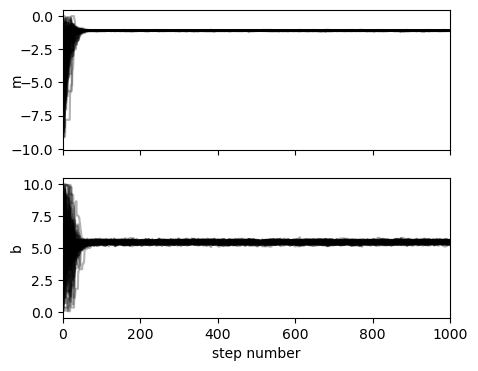

In [12]:
fig, axes = plt.subplots(2, figsize=(5, 4), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    plot_chains(axes[i], samples, i, labels)

axes[-1].set_xlabel("step number")

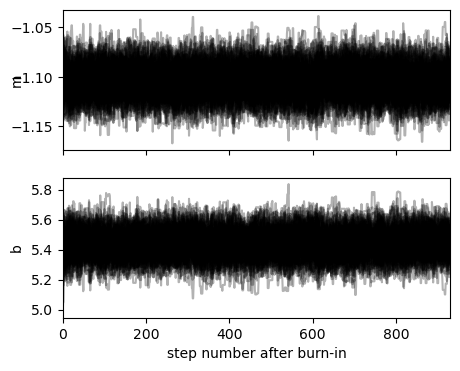

In [13]:
flat_samples = sampler.get_chain(discard=70)

fig, axes = plt.subplots(2, figsize=(5, 4), sharex=True)
labels = ["m", "b"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/sampling/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (930) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


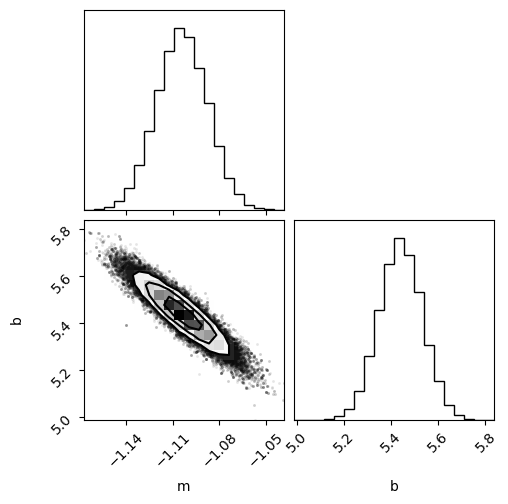

In [14]:
import corner

fig = corner.corner(flat_samples, labels=labels)

In [16]:
meds = []
for i in range(ndim):
    meds.append(np.median(flat_samples[:,:,i][1]))

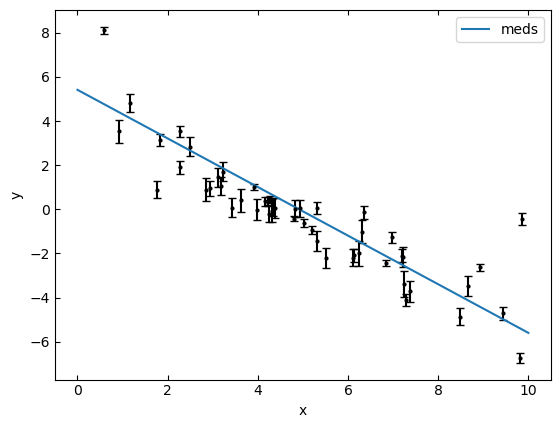

In [18]:
fig, ax = plt.subplots()
plot_data(ax, df['x'], df['y'], df['y_err'])
x_arr = np.linspace(0, 10, 100)
ax.plot(x_arr, get_model_predictions(meds, x_arr), label='meds')
ax.legend()

b) 

In [15]:
import pymc3 as pm
import pymc3_ext as pmx

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [25]:
with pm.Model() as model:
    m = pm.Uniform("m", lower=-10, upper=0)
    b = pm.Uniform("b", lower=0, upper=10)
    y_mod = pm.Deterministic("y_model", m * df['x'] + b)

    lnlike = pm.Normal("lnlike", mu=y_mod, observed=df['y'])

with model:
    trace = pmx.sample(chains=2, tune=1000, draws=1000, target_accept=0.9, return_inferencedata=True)


You can find the C code in this temporary file: /var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/theano_compilation_error_oykv4a4b
library imit=] is not found.


Exception: ('Compilation failed (return status=1): In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:25:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/stdio.h:101:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:48:8: warning: "Libc++ only supports Clang 16 and later" [-W#warnings]. #      warning "Libc++ only supports Clang 16 and later".        ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:358:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/abs.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: error: expected identifier or \'{\'. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:358:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/abs.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: error: C++ requires a type specifier for all declarations. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:358:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/abs.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: error: expected expression. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:885:32: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'.                                inline namespace _LIBCPP_ABI_NAMESPACE {.                                ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:358:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/abs.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:35:26: error: expected \';\' after top level declarator. _LIBCPP_END_NAMESPACE_STD.                          ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:359:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/copysign.h:16:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/limits:819:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/type_traits:425:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/add_pointer.h:17:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/remove_reference.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/cstddef:57:1: error: expected identifier or \'{\'. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:359:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/copysign.h:16:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/limits:819:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/type_traits:425:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/add_pointer.h:17:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/remove_reference.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/cstddef:57:1: error: C++ requires a type specifier for all declarations. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:359:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/copysign.h:16:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/limits:819:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/type_traits:425:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/add_pointer.h:17:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/remove_reference.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/cstddef:57:1: error: expected expression. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:885:32: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'.                                inline namespace _LIBCPP_ABI_NAMESPACE {.                                ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:359:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__math/copysign.h:16:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/limits:819:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/type_traits:425:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/add_pointer.h:17:. In file included from /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/remove_reference.h:13:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/cstddef:67:26: error: expected \';\' after top level declarator. _LIBCPP_END_NAMESPACE_STD.                          ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:415:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::signbit;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:419:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isfinite;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:420:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isgreater;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:421:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isgreaterequal;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:422:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isinf;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:423:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isless;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:424:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::islessequal;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:425:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::islessgreater;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:426:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isnan;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:427:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isnormal;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. In file included from /Users/nasserm/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.9.22-64/tmpvzgl2zvs/mod.cpp:1:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/Python.h:50:. In file included from /opt/anaconda3/envs/sampling/include/python3.9/pyport.h:205:. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/math.h:428:7: error: \'std\' is not a class, namespace, or enumeration. using std::__math::isunordered;.       ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__type_traits/enable_if.h:18:1: note: \'std\' declared here. _LIBCPP_BEGIN_NAMESPACE_STD. ^. /opt/anaconda3/envs/sampling/bin/../include/c++/v1/__config:884:81: note: expanded from macro \'_LIBCPP_BEGIN_NAMESPACE_STD\'. #  define _LIBCPP_BEGIN_NAMESPACE_STD namespace _LIBCPP_TYPE_VISIBILITY_DEFAULT std {                                  \\.                                                                                 ^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 1 warning and 20 errors generated.. ', 'FunctionGraph(Elemwise{add,no_inplace}(TensorConstant{0.0}, TensorConstant{-10.0}))')

In [19]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(mu=0, sigma=None, tau=None, sd=None, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |       

In [ ]:
with pm.Model() as model:
    m = pm.Uniform("m", lower=-10, upper=10)
    b = pm.Uniform("b", lower=-10, upper=10)

    y_mod = pm.Deterministic("y_mod", m * df['x'] + b)

    lnlike = pm.Normal("lnlike", mu=y_mod, observed=df['y'])

    with model:
        trace = pmx.sample(chains=2, tune=1000, draws=1000, target_accept=0.9, return_inferencedata=True)

c)

In [32]:
from dynesty import DynamicNestedSampler
import dynesty

def prior_transform(u):
    """
    Transforms samples `u` from the unit hypercube to the prior volume.
    u: array-like, samples from U[0,1]
    Returns: array-like, transformed parameters [m, b]
    """
    m = u[0] * (0 - -10) + -10  # m ~ U(m_min, m_max)
    b = u[1] * (10 - 0) + 0  # b ~ U(b_min, b_max)
    return np.array([m, b])

In [28]:
# Define the dimensionality of our problem.
ndim = 2


# Define our uniform prior via the prior transform.
def ptform(u):
    return 20. * u - 10.

In [35]:
sampler = dynesty.NestedSampler(
    lnlikelihood,
    prior_transform,
    ndim,
    nlive=500,
    logl_args=(df['x'], df['y'], df['y_err']), # Pass data to likelihood
    bound='multi',  # Bounding method
    sample='rwalk', # Sampling method (random walk is robust)
    # queue_size=4 # Can speed up if you have multiple cores and likelihood is slow
)

In [36]:
sampler.run_nested()

5649it [00:29, 189.28it/s, +500 | bound: 53 | nc: 1 | ncall: 104387 | eff(%):  5.919 | loglstar:   -inf < -398.865 <    inf | logz: -409.307 +/-  0.137 | dlogz:  0.001 >  0.509]


In [37]:
results = sampler.results

In [39]:
results.summary()

Summary
nlive: 500
niter: 5649
ncall: 103887
eff(%):  5.919
logz: -409.307 +/-  0.253


In [40]:
from dynesty import plotting as dyplot

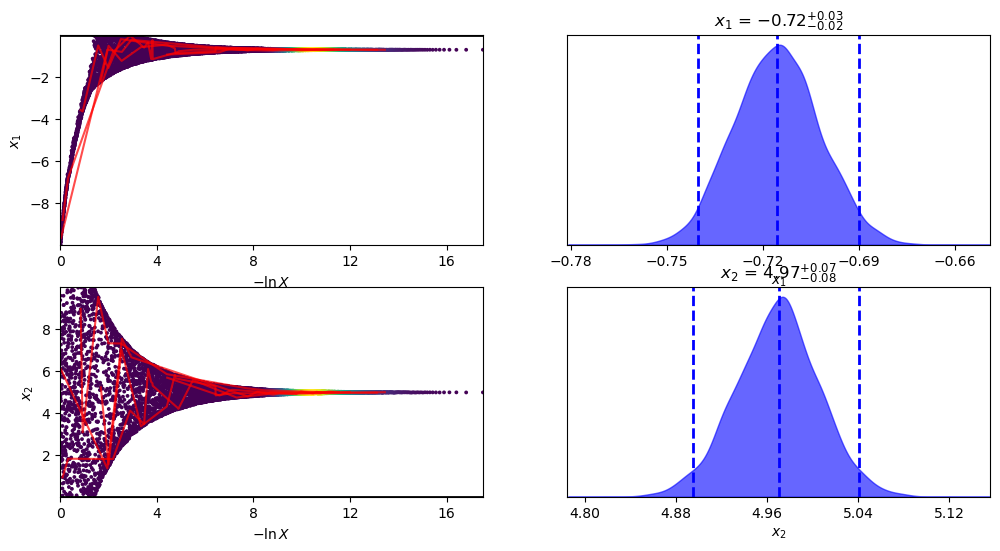

In [41]:
fig, axes = dyplot.traceplot(results, truths=np.zeros(ndim),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5))


ValueError: Provided axes do not match the required shape

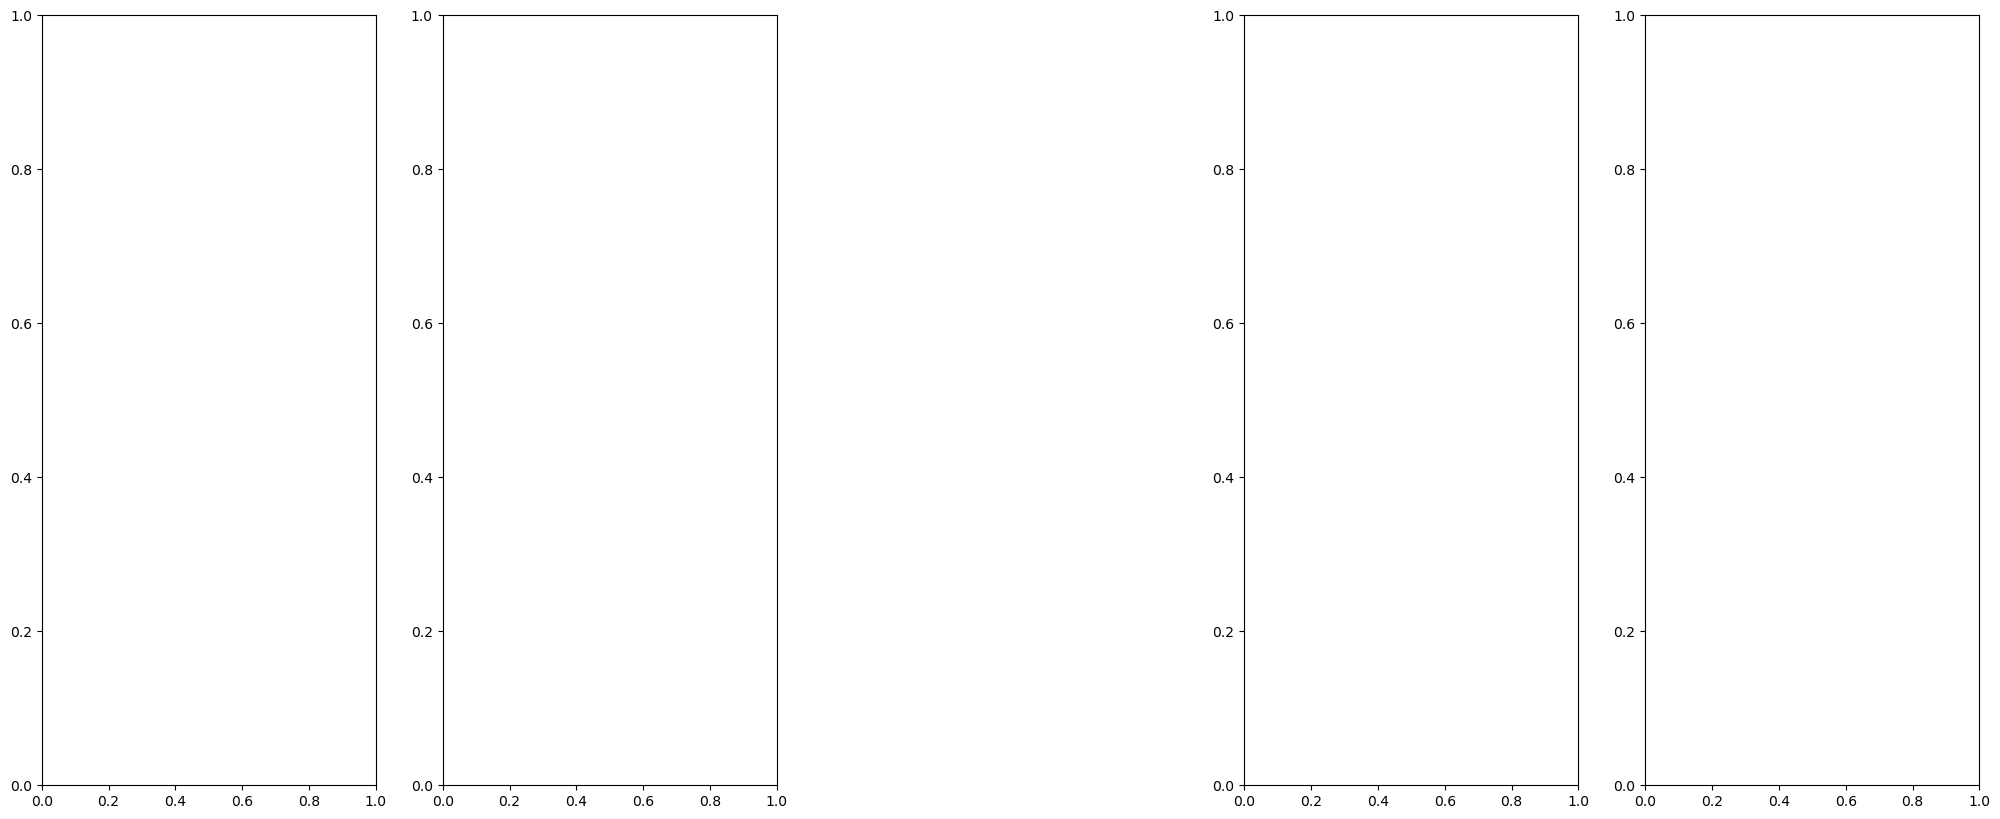

In [50]:
# initialize figure
fig, axes = plt.subplots(1, 5, figsize=(25, 10))
axes = axes.reshape((1, 5))  # reshape axes

# add white space
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (res1; left)
fg, ax = dyplot.cornerpoints(results, cmap='plasma', truths=np.zeros(ndim),
                             kde=False, fig=(fig, axes[:, :2]))



# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.